In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sunpy
import sunpy.map
from sunpy.coordinates import get_earth, get_horizons_coord
import astropy
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as const
import eispac

import cmcrameri.cm as cmcm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, 
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)

from astropy.visualization import (AsinhStretch, LinearStretch,
        LogStretch, ImageNormalize)
# import juanfit

In [2]:
def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14,
                  bbox_to_anchor=(1.02, 0., 1, 1),orientation="vertical"):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=bbox_to_anchor,
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

In [3]:
def plot_eis_fov(eis_map, map_project_to, map_ax, 
                 color="red", alpha=0.7):
    map_project_to.draw_quadrangle(
    [0,0]*u.pix,
    top_right=u.Quantity(eis_map.dimensions),
    label='EIS',
    edgecolor=color,
    lw=2,
    alpha=alpha,
    transform=map_ax.get_transform(eis_map.wcs),
    axes=map_ax,
)

In [6]:
def plot_eis_fov_offlimb(eis_map, map_project_to, map_ax, 
                 color="red", alpha=0.7):
    
    with sunpy.coordinates.Helioprojective.assume_spherical_screen(map_project_to.observer_coordinate,only_off_disk=True):

        bottom_left = eis_map.bottom_left_coord.transform_to(map_project_to.coordinate_frame)
        top_right = eis_map.top_right_coord.transform_to(map_project_to.coordinate_frame)
    
        map_project_to.draw_quadrangle(
        bottom_left,
        top_right=top_right,
        label='EIS',
        edgecolor=color,
        lw=2,
        alpha=alpha,
        axes=map_ax,
)

In [4]:
def plot_eui_hri(eui_file, vmin=0, vmax=5e4, asin_a=0.01 ,eis_file=None):
    eui_map = sunpy.map.Map(eui_file)

    fig = plt.figure(figsize=(10,4),constrained_layout=True)

    ax = fig.add_subplot(1,2,1,projection=eui_map)

    ax.imshow(eui_map.data, cmap="solar orbiterhri_euv174",origin="lower", 
            norm=ImageNormalize(stretch=AsinhStretch(a=asin_a), vmin=vmin, vmax=vmax))

    plot_colorbar(ax=ax,im=ax.images[0],bbox_to_anchor=(1.02, 0., 1, 1),fontsize=10)

    ax.set_title("EUI/HRI EUV 17.4 nm {}".format(eui_map.date_average.strftime("%Y-%m-%d %H:%M:%S")),fontsize=10)
    ax.tick_params(direction="in",labelsize=10)
    ax.grid("on",alpha=0.2,color="white")
    ax.set_xlabel("Solar-X [arcsec]",fontsize=10)
    ax.set_ylabel("Solar-Y [arcsec]",fontsize=10)

    if eis_file is not None:
        eis_fitres = eispac.read_fit(eis_file)
        eis_int_map = eis_fitres.get_map(component=0, measurement="intensity")
        plot_eis_fov(eis_int_map, eui_map, ax, color="red", alpha=0.7)
        

    ax_solo = fig.add_subplot(1,2,2,projection="polar")
    ax_solo.plot(0, 0, marker='o', markersize=20, label='Sun', color='yellow')

# Plot the satellite locations
    obstime = eui_map.date_average
    for body_name in ['Earth', 'SDO', 'Solar Orbiter']:
        if body_name == 'Earth':
            body = get_earth(obstime)
        else:
            body = get_horizons_coord(body_name, time=obstime)
        p, = ax_solo.plot(body.lon.to('rad'), body.radius.to(u.AU), 'o', label=body_name)
        ax_solo.plot([body.lon.to_value('rad'), 0], [body.radius.to_value(u.AU), 0], ls='--', color=p.get_color())

    ax_solo.set_theta_zero_location("S")
    ax_solo.set_rlabel_position(90)
    ax_solo.set_rlim(0, 1.3)
    ax_solo.legend()

    return (fig, ax, ax_solo, eui_map)

In [5]:
def plot_aia_eis(aia_file, eis_file, vmin=0, vmax=1e3, asin_a=0.01, 
                 top_right=[-700,400],bottom_left=[-1000,100],offlimb=False):
    aia_map = sunpy.map.Map(aia_file)
    aia_map_corp = aia_map.submap(bottom_left=SkyCoord(*bottom_left*u.arcsec, frame=aia_map.coordinate_frame),
                                  top_right=SkyCoord(*top_right*u.arcsec, frame=aia_map.coordinate_frame))
    
    fig = plt.figure(figsize=(5,5),constrained_layout=True)

    ax = fig.add_subplot(projection=aia_map_corp)
    ax.imshow(aia_map_corp.data, cmap="sdoaia193",origin="lower",
              norm=ImageNormalize(stretch=AsinhStretch(a=asin_a), vmin=vmin, vmax=vmax))
    
    plot_colorbar(ax=ax,im=ax.images[0],bbox_to_anchor=(1.02, 0., 1, 1),fontsize=10)

    ax.set_title("SDO/AIA 19.3 nm {}".format(aia_map.date.strftime("%Y-%m-%d %H:%M:%S")),fontsize=10)
    ax.tick_params(direction="in",labelsize=10)
    ax.grid("on",alpha=0.2,color="white")
    ax.set_xlabel("Solar-X [arcsec]",fontsize=10)
    ax.set_ylabel("Solar-Y [arcsec]",fontsize=10)

    eis_fitres = eispac.read_fit(eis_file)
    eis_int_map = eis_fitres.get_map(component=0, measurement="intensity")

    if offlimb is True:
        plot_eis_fov_offlimb(eis_int_map, aia_map_corp, ax)
    else:
        plot_eis_fov(eis_int_map, aia_map_corp, ax)
    
    return (fig, ax, aia_map_corp)

In [8]:
def plot_eis_dhb(fitres_path, figsize=(6,6), inst_width="eis_software",
                    vminmax = {"intensity":(0,5e3),"vel":(-15,15),"width":(0,40)}, logT_th_dlambda=6.2,
                    rest_wvl=195.119,line_name="Fe XII 19.51 nm"):
    
    c = const.c.cgs.value
    amu = const.u.cgs.value
    k_B = const.k_B.cgs.value
     
    fit_res = eispac.read_fit(fitres_path)

    int_map = fit_res.get_map(component=0, measurement="intensity")
    vel_map = fit_res.get_map(component=0, measurement="vel")
    width_map = fit_res.get_map(component=0, measurement="width")

    if inst_width == "eis_software":
        true_width_fwhm = np.sqrt( (width_map.data * np.sqrt(8*np.log(2)))**2 - fit_res.meta["slit_width"][:,np.newaxis]**2)
    elif isinstance(inst_width,(float,int,np.number)):
        true_width_fwhm = np.sqrt( (width_map.data * np.sqrt(8*np.log(2)))**2 - inst_width**2)
    else:
        true_width_fwhm = width_map.data * np.sqrt(8*np.log(2))

    v1oe = true_width_fwhm/np.sqrt(4*np.log(2))*c/rest_wvl
    vth2 = 2*k_B*10**logT_th_dlambda/amu/55.85
    vnth = np.sqrt(v1oe**2 - vth2)


    fig = plt.figure(figsize=figsize, constrained_layout=True)

    ax1 = fig.add_subplot(1,3,1,projection=int_map)

    int_map_data_norm = ImageNormalize(int_map.data, stretch=AsinhStretch(a=0.01),vmin=vminmax["intensity"][0],vmax=vminmax["intensity"][1])

    ax1.imshow(int_map.data, aspect=fit_res.meta["aspect"], cmap=plt.get_cmap("sdoaia193"),
               norm=int_map_data_norm, origin="lower")
    
    clb1, clb_ax1 = plot_colorbar(im=ax1.images[0],ax=ax1,width="5%",fontsize=10)
    
    ax1.set_title("{} Intensity".format(line_name),pad=10)

    ax1.text(0.98,0.03,"{}".format(int_map.date_average.strftime("%Y-%m-%d %H:%M:%S")),transform=ax1.transAxes,fontsize=10,
                ha="right",va="bottom")

    ax2 = fig.add_subplot(1,3,2,projection=vel_map)

    ax2.imshow(vel_map.data, aspect=fit_res.meta["aspect"], cmap=cmcm.vik,
               vmin=vminmax["vel"][0], vmax=vminmax["vel"][1], origin="lower")
    
    clb2, clb_ax2 = plot_colorbar(im=ax2.images[0],ax=ax2,width="5%",fontsize=10)

    ax2.set_title("Doppler Shift [km/s]",pad=10)
    
    ax3 = fig.add_subplot(1,3,3,projection=width_map)
    
    ax3.imshow(vnth/1e5, aspect=fit_res.meta["aspect"], cmap=cmcm.batlowK,
               vmin=vminmax["width"][0], vmax=vminmax["width"][1], origin="lower")
    
    clb3, clb_ax3 = plot_colorbar(im=ax3.images[0],ax=ax3,width="5%",fontsize=10)

    ax3.set_title("Nonthermal Velocity [km/s]",pad=10)

    # for clb_ax_ in (clb_ax1,clb_ax2,clb_ax3):
    #     clb_ax_.tick_params(axis="x",labelbottom=False,labeltop=True,top=True,bottom=False)
    #     clb_ax_.ticklabel_format(axis="x",style="sci",scilimits=(0,2),useMathText=True)

    #     try:
    #         clb_ax_.xaxis.get_offset_text().set_visible(False)
    #     except:
    #         pass

    for ax_ in (ax1,ax2,ax3):
        ax_.set_xlabel("Solar X [arcsec]")
    
    ax1.set_ylabel("Solar Y [arcsec]")

    for ax_ in (ax2,ax3):
        ax_.tick_params(axis="y",labelleft=False)

    for ax_ in (ax1,ax2,ax3):
        ax_.tick_params(direction="in",which="both")

    return (fig, ax1, ax2, ax3, int_map, vel_map, width_map)

### Hinode/EIS DHB_007_v2 Large FOV Scan
2022-10-25 20:11 - 22:52

Reading fit result from, 
   ../../../src/EIS/DHB_007_v2/20221025T2011/eis_20221025_201113.fe_12_195_119.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


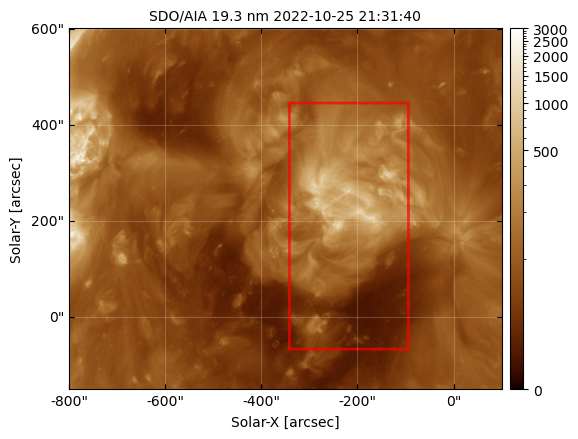

In [14]:
_ = plot_aia_eis(aia_file="../../../src/AIA/193/lvl15/aia_lev15_193a_2022_10_25t21_31_40_84z_image_lev15.fits",
             eis_file="../../../src/EIS/DHB_007_v2/20221025T2011/eis_20221025_201113.fe_12_195_119.1c-0.fit.h5",
             offlimb=False,bottom_left=[-800,-150],top_right=[100,600],vmax=3e3)

Reading fit result from, 
   ../../../src/EIS/DHB_007_v2/20221025T2011/eis_20221025_201113.fe_12_195_119.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_119224/2880064979.py:16: RuntimeWarning: invalid value encountered in sqrt
  true_width_fwhm = np.sqrt( (width_map.data * np.sqrt(8*np.log(2)))**2 - fit_res.meta["slit_width"][:,np.newaxis]**2)
/tmp/ipykernel_119224/2880064979.py:24: RuntimeWarning: invalid value encountered in sqrt
  vnth = np.sqrt(v1oe**2 - vth2)


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


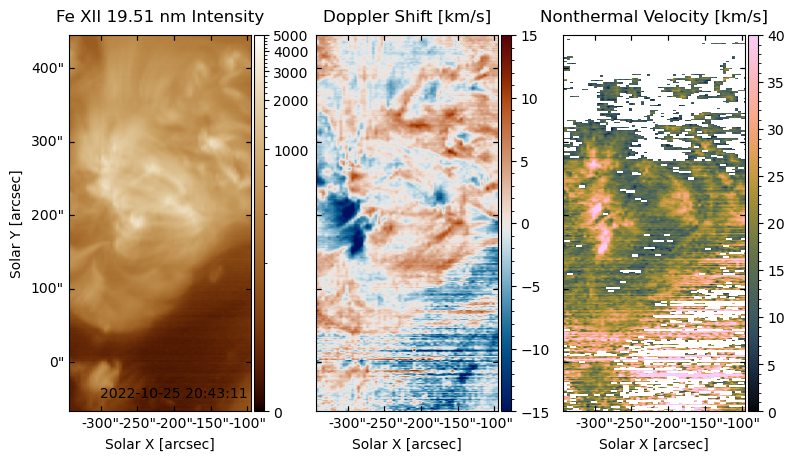

In [13]:
_ = plot_eis_dhb("../../../src/EIS/DHB_007_v2/20221025T2011/eis_20221025_201113.fe_12_195_119.1c-0.fit.h5",
             figsize=(8,4.5))

In [ ]:
_ = plot_aia_eis(aia_file="../../../src/AIA/193/lvl15/aia_lev15_193a_2022_10_25t21_31_40_84z_image_lev15.fits",
             eis_file="../../../src/EIS/DHB_007_v2/20221025T2011/eis_20221025_201113.fe_12_195_119.1c-0.fit.h5",
             offlimb=False,bottom_left=[-800,-150],top_right=[0,600],vmax=3e3)